In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

In [8]:
N = 50
x_all = [0.0]*N
y_all = [0.0]*N
box = 10  # Angstrom

k=0
for i in range (0,int(N/5)):
    for j in range(0,int(N/10)):
        x_all[k] = i*0.1*box + (np.random.rand()-0.5)*0.05*box
        if math.fmod(i,2) == 0.0:
#            y_all[k] = j*0.2*box + (np.random.rand()-0.5)*0.1
            y_all[k] = j*0.2*box + (np.random.rand()-0.5)*0.05*box
        else:
#            y_all[k] = j*0.2*box + 0.1 + (np.random.rand()-0.5)*0.1
            y_all[k] = j*0.2*box + 0.1*box + (np.random.rand()-0.5)*0.05*box
        k=k+1

x_start = [0.0]*N
y_start = [0.0]*N
for i in range (0,N):
    x_start[i] = x_all[i]
    y_start[i] = y_all[i]


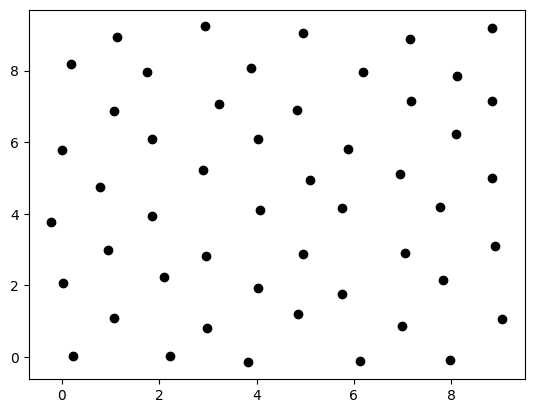

In [9]:
##  Visualize starting configuration  ##

for i in range(0,N):
    plt.scatter(x_start[i],y_start[i],c='k')
plt.show()


In [57]:
###  Use this for Simple Pairwise Potential  ##

def force(x_all,y_all):

    en = 0
    c = -1E-26/N  # Joules.Angstrom
    rc = 5  # Angstrom
    forces_x = [0.0]*N
    forces_y = [0.0]*N

    for i in range (0,N-1):
        for j in range (i+1,N):
            xr = x_all[i] - x_all[j]
            xr = xr - box*np.round(xr/box)
            yr = y_all[i] - y_all[j]
            yr = yr - box*np.round(yr/box)
            r = np.sqrt(xr*xr + yr*yr)
            if r <= rc:
                ff = (c/(r*r))*1E10  # converting to J/m
                forces_x[i] = forces_x[i] + ff*(xr/r)
                forces_x[j] = forces_x[j] - ff*(xr/r)
                forces_y[i] = forces_y[i] + ff*(yr/r)
                forces_y[j] = forces_y[j] - ff*(yr/r)
                en = en + c/r

    return(en,forces_x,forces_y)


In [58]:
en,forces_x,forces_y = force(x_start,y_start)

In [59]:
en

-6.556938606386176e-26

In [60]:
###  Use this for Calculating Average Pairwise Distances  ##

def pair_distance(x_all,y_all):

    k = 0
    dist_avg = 0

    for i in range (0,N-1):
        for j in range (i+1,N):
            xr = x_all[i] - x_all[j]
            xr = xr - box*np.round(xr/box)
            yr = y_all[i] - y_all[j]
            yr = yr - box*np.round(yr/box)
            r = np.sqrt(xr*xr + yr*yr)
            dist_avg = dist_avg + r
            k = k+1

    dist_avg = dist_avg/k

    return(dist_avg)


In [61]:
##  Define MD Parameters  ##

Temp_start = 300  # Kelvin
m = 4.48E-26  # kg
dt = 1e-12  # seconds
kB = 1.380649E-23  # J/K


In [73]:
def init():

    x = [0.0]*N
    y = [0.0]*N
    xm = [0.0]*N
    ym = [0.0]*N

    vx = [0.0]*N
    vy = [0.0]*N
    sumvx = 0
    sumvy = 0
    sumv2 = 0

    k = 0
    for i in range (0,int(N/5)):
        for j in range(0,int(N/10)):
            x[k] = i*0.1*box + (np.random.rand()-0.5)*0.05*box
            if math.fmod(i,2) == 0.0:
                y[k] = j*0.2*box + (np.random.rand()-0.5)*0.05*box
            else:
                y[k] = j*0.2*box + 0.1*box + (np.random.rand()-0.5)*0.05*box
            k=k+1

    k = 0
    for i in range (0,int(N/5)):
        for j in range(0,int(N/10)):
            xm[k] = i*0.1*box + (np.random.rand()-0.5)*0.01*box
            if xm[k] >= box:
                xm[k] = xm[k] - int(xm[k])
            if xm[k] < 0.0:
                xm[k] = xm[k] - int(xm[k]) + box
            if math.fmod(i,2) == 0.0:
                ym[k] = j*0.2*box + (np.random.rand()-0.5)*0.01*box
            else:
                ym[k] = j*0.2*box + 0.1*box + (np.random.rand()-0.5)*0.01*box
            if ym[k] >= box:
                ym[k] = ym[k] - int(ym[k])
            if ym[k] < 0.0:
                ym[k] = ym[k] - int(ym[k]) + box
            k=k+1

    for i in range(0,N):
        xr = x[i] - xm[i]
        xr = xr - box*np.round(xr/box)
        vx[i] = (xr/dt)*1E-10  # m/s
        yr = y[i] - ym[i]
        yr = yr - box*np.round(yr/box)
        vy[i] = (yr/dt)*1E-10  # m/s


    for i in range(0,N):
        sumvx = sumvx + vx[i]
        sumvy = sumvy + vy[i]
        sumv2 = sumv2 + vx[i]*vx[i] + vy[i]*vy[i]

    sumvx = sumvx/N
    sumvy = sumvy/N
    sumv2 = sumv2/(2*N)

    fs = np.sqrt(2*kB*Temp_start/(m*sumv2))
    sumv2 = 0

    for i in range(0,N):
        vx[i] = (vx[i] - sumvx)*fs
        vy[i] = (vy[i] - sumvy)*fs
        sumv2 = sumv2 + vx[i]*vx[i] + vy[i]*vy[i]
        xm[i] = x[i] - vx[i]*dt
        ym[i] = y[i] - vy[i]*dt

    PE_start, fx, fy = force(x,y)
    KE_start = (0.5*sumv2*m)
    Temp = KE_start/(kB*2*N)

    return(x, y, vx, vy, xm, ym, PE_start, KE_start, Temp)


In [74]:
x, y, vx, vy, xm, ym, PE_start, KE_start, Temp = init()

In [75]:
Temp_start

300

In [76]:
Temp

295.4721551186601

In [79]:
def integrate(en, forces_x, forces_y, x, xm, y, ym):

    sumvx = 0
    sumvy = 0
    sumv2 = 0
    vx = [0.0]*N
    vy = [0.0]*N

    for i in range(0,N):

        xr = x[i] - xm[i]
        xr = xr - box*np.round(xr/box)
        xx = x[i] + xr + (dt*dt*forces_x[i]/m)*1E10
        if xx >= box:
          xx = xx - int(xx)
        if xx < 0.0:
          xx = xx - int(xx) + box

        yr = y[i] - ym[i]
        yr = yr - box*np.round(yr/box)
        yy = y[i] + yr + (dt*dt*forces_y[i]/m)*1E10
        if yy >= box:
          yy = yy - int(yy)
        if yy < 0.0:
          yy = yy - int(yy) + box

        xr = xx - xm[i]
        xr = xr - box*np.round(xr/box)
        vx[i] = (xr/(2*dt))*1E-10  # m/s
        yr = yy - ym[i]
        yr = yr - box*np.round(yr/box)
        vy[i] = (yr/(2*dt))*1E-10  # m/s
        sumvx = sumvx + vx[i]
        sumvy = sumvy + vy[i]
        sumv2 = sumv2 + vx[i]*vx[i] + vy[i]*vy[i]
        xm[i] = x[i]
        x[i] = xx
        ym[i] = y[i]
        y[i] = yy

    pot = en
    kin = (0.5*sumv2*m)
    etot = pot + kin
    Temp = kin/(kB*2*N)

#    etot = (en + 0.5*sumv2)/N

    return(Temp, pot, kin, etot, x, y, xm, ym)



In [80]:
def sample(x,y):

    return(pair_distance(x,y))


In [81]:
def md(tmax,dt,nsamp):

    x, y, vx, vy, xm, ym, pe_start, ke_start, temp_start = init()
    t = 0
    steps = round(tmax/dt)
    s = int(steps/nsamp)
    times = [0.0]*s
    PE = [0.0]*s
    KE = [0.0]*s
    TE = [0.0]*s
    Temp = [0.0]*s
    pair_dist = [0.0]*s
    k = 0
    x_start = copy.deepcopy(x)
    y_start = copy.deepcopy(y)

    for i in range(0,steps):
        en, fx, fy = force(x,y)
        T, pe, ke, te, x, y, xm, ym = integrate(en, fx, fy, x, xm, y, ym)
        t = t+dt
        if math.fmod(i, nsamp) == 0.0:
            k = int(i/nsamp)
            PE[k] = pe
            KE[k] = ke
            TE[k] = te
            Temp[k] = T
            times[k] = t
            pair_dist[k] = sample(x,y)
        # xm = copy.deepcopy(xm_new)
        # ym = copy.deepcopy(ym_new)
        # x = copy.deepcopy(x_new)
        # y = copy.deepcopy(y_new)

#     plt.plot(times[:], PE[:], c = 'r')
#     plt.plot(times[:], KE[:], c = 'b')
#     plt.plot(times[:], TE[:], c = 'grey')
#     plt.plot(times[:], Temp[:], c='k')
#     plt.plot(times[:], pair_dist[:], c = 'g')

    return(PE, KE, TE, Temp, x_start, y_start, x, y, pair_dist, times)



In [82]:
tmax = 5e-9 # seconds
dt = 1e-12  # seconds
nsamp = 10

PE, KE, TE, Temp, x_start, y_start, x_final, y_final, pair_dist, times = md(tmax,dt,nsamp)


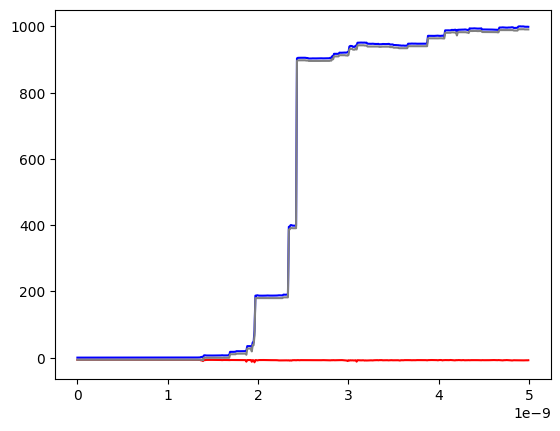

In [83]:
for i in range(0,len(times)):
    PE[i] = PE[i]*1e+26
    KE[i] = KE[i]*1e+26
    TE[i] = TE[i]*1e+26

plt.plot(times[:], PE[:], c = 'r')
plt.plot(times[:], KE[:], c = 'b')
plt.plot(times[:], TE[:], c = 'grey')


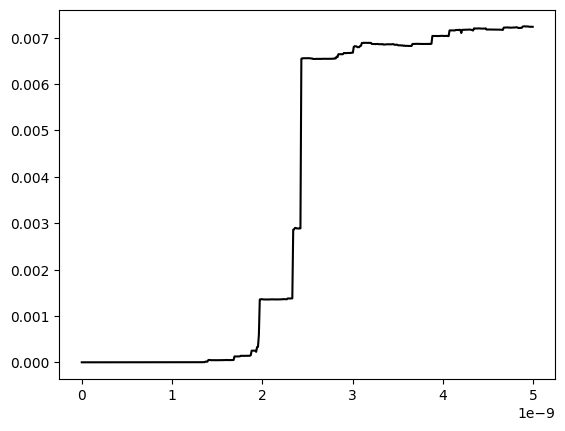

In [84]:
plt.plot(times[:], Temp[:], c='k')


In [72]:
Temp

[1.1171743294251144e-13,
 4.887108636624512e-11,
 1.8628263678861394e-10,
 4.124413977128859e-10,
 7.275038355469732e-10,
 1.1316880532971016e-09,
 1.6252740687976436e-09,
 2.208604172721097e-09,
 2.8820833668831925e-09,
 3.6461798841955413e-09,
 4.50142579256119e-09,
 5.448417682973667e-09,
 6.48781744422896e-09,
 7.620353126975056e-09,
 8.846819898830895e-09,
 1.0168081092893812e-08,
 1.158506935392448e-08,
 1.3098787884164114e-08,
 1.4710311792610073e-08,
 1.6420789552607535e-08,
 1.823144457050977e-08,
 2.014438453465816e-08,
 2.2160731858772952e-08,
 2.428153605652769e-08,
 2.6508339399324674e-08,
 2.8842768886470816e-08,
 3.128653860029288e-08,
 3.3841452213488444e-08,
 3.650940566055536e-08,
 3.9292389979643996e-08,
 4.2192494334110025e-08,
 4.521190922668081e-08,
 4.835292991348502e-08,
 5.161865606681145e-08,
 5.501503782660796e-08,
 5.8540903778365515e-08,
 6.21990112417417e-08,
 6.599639322621426e-08,
 6.994009402656438e-08,
 7.402578947678813e-08,
 7.825677812989487e-08,
 8

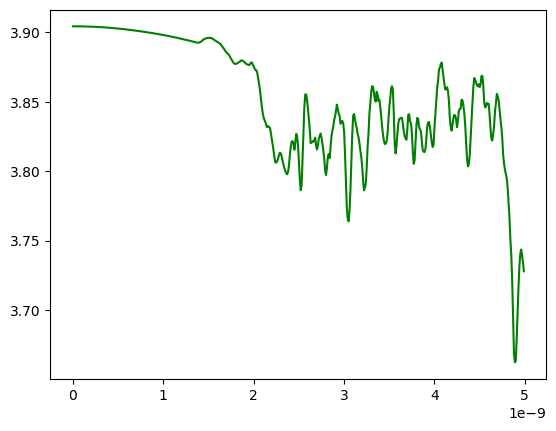

In [85]:
plt.plot(times[:], pair_dist[:], c = 'g')

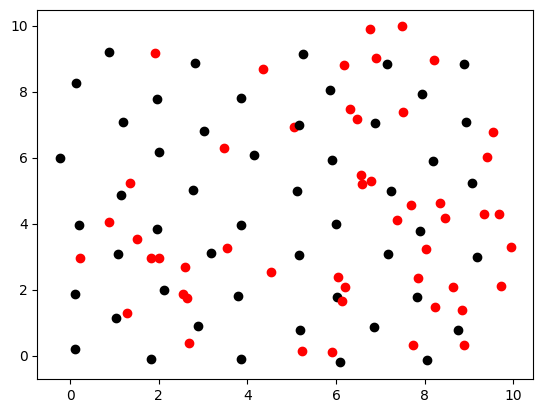

In [86]:
for i in range(0,N):
    plt.scatter(x_start[i],y_start[i],c='k')
    plt.scatter(x_final[i],y_final[i],c='r')
plt.show()


In [95]:
## Run this cell only for Anderson thermostat (to keep temp fixed) ##

def integrate(switch, en, forces_x, forces_y, x, y, vx, vy, temp, dt):

    sumv2 = 0
    vx = [0.0]*N
    vy = [0.0]*N
    nu = 8*(1e11)
    Temp = 0


    if switch == 1:

        for i in range(0,N):

            x[i] = x[i] + vx[i]*(1E10)*dt + dt*dt*forces_x[i]*(1E10)/(2*m)
            if x[i] >= box:
                x[i] = x[i] - int(x[i])
            if x[i] < 0.0:
                x[i] = x[i] - int(x[i]) + box
            vx[i] = vx[i] + dt*forces_x[i]/(2*m)

            y[i] = y[i] + vy[i]*(1E10)*dt + dt*dt*forces_y[i]*(1E10)/(2*m)
            if y[i] >= box:
                y[i] = y[i] - int(y[i])
            if y[i] < 0.0:
                y[i] = y[i] - int(y[i]) + box
            vy[i] = vy[i] + dt*forces_y[i]/(2*m)


    elif switch == 2:

        tempa = 0

        for i in range(0,N):
            vx[i] = vx[i] + dt*forces_x[i]/(2*m)
            vy[i] = vy[i] + dt*forces_y[i]/(2*m)
            tempa = tempa + ((vx[i]*vx[i]+vy[i]*vy[i])*m)/kB
        tempa = tempa/(2*N)
        sigma = np.sqrt(kB*temp/m)
        samples = np.random.normal(loc=0, scale=sigma, size=1000)
        for i in range(0,N):
            if np.random.rand() < nu*dt:
                vx[i] = samples[np.random.randint(0,1000)]
                vy[i] = samples[np.random.randint(0,1000)]

        Temp = Temp + tempa

    sumv2 = sumv2 + vx[i]*vx[i] + vy[i]*vy[i]

    pot = en
    kin = (0.5*sumv2*m)
    etot = pot + kin
#    Temp = kin/kB

#    etot = (en + 0.5*sumv2)/N

    return(Temp, pot, kin, etot, x, y, vx, vy)



In [ ]:
sigma = np.sqrt(2*kB*Temp_start/m)
samples = np.random.normal(loc=0, scale=sigma, size=1000)
vx = [0.0]*N
vy = [0.0]*N
sumv2 = 0
for i in range(0,N):
    vx[i] = samples[np.random.randint(0,1000)]
    vy[i] = samples[np.random.randint(0,1000)]
    sumv2 = sumv2 + vx[i]*vx[i] + vy[i]*vy[i]
print(Temp_start, ',', m*sumv2/(2*N*kB))

300 , 618.9701977662103


In [ ]:
nu = 5*(1e11)
print(nu*dt)

0.5


In [ ]:
m*samples[0]*samples[0]/kB

49.252351982879944

In [ ]:
## Example of Gaussian distribution ##

import numpy as np

sigma = 2.5  # Set the desired sigma value
samples = np.random.normal(loc=0, scale=sigma, size=1000)

# Print some of the samples
print(samples[:10])

plt.hist(samples, bins=50)
plt.show()

In [97]:
def md_anderson(tmax,dt,nsamp,T):

    x, y, vx, vy, xm, ym, pe_start, ke_start, temp_start = init()
    en, fx, fy = force(x,y)
    t = 0
    steps = round(tmax/dt)
    s = int(steps/nsamp)
    times = [0.0]*s
    PE = [0.0]*s
    KE = [0.0]*s
    TE = [0.0]*s
    Temp = [0.0]*s
    pair_dist = [0.0]*s

    x_start = copy.deepcopy(x)
    y_start = copy.deepcopy(y)
    k = 0

    for i in range(0,steps):
        T, pe, ke, te, x, y, vx, vy = integrate(1, en, fx, fy, x, y, vx, vy, T, dt)
        en, fx, fy = force(x,y)
        T, pe, ke, te, x, y, vx, vy = integrate(2, en, fx, fy, x, y, vx, vy, T, dt)
        t = t+dt
        if math.fmod(i, nsamp) == 0.0:
            k = int(i/nsamp)
            PE[k] = pe
            KE[k] = ke
            TE[k] = te
            Temp[k] = T
            times[k] = t
            pair_dist[k] = sample(x,y)

    return(PE, KE, TE, Temp, x_start, y_start, x, y, pair_dist, times)


In [98]:
Temp_hold = 300  # Kelvin
tmax = 1e-9 # seconds
dt = 1e-12  # seconds
nsamp = 10

PE, KE, TE, Temp, x_start, y_start, x_final, y_final, pair_dist, times = md_anderson(tmax,dt,nsamp,Temp_hold)


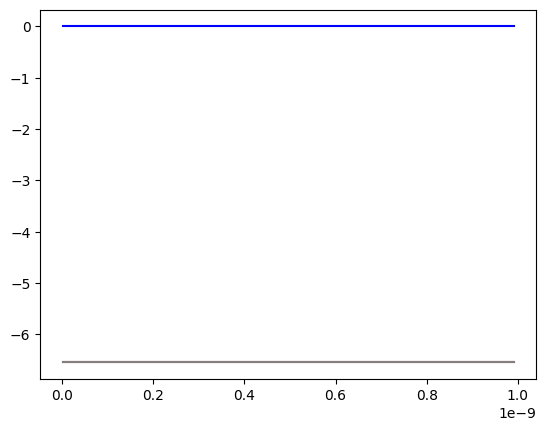

In [99]:
for i in range(0,len(times)):
    PE[i] = PE[i]*1e26
    KE[i] = KE[i]*1e26
    TE[i] = TE[i]*1e26

plt.plot(times[:], PE[:], c = 'r')
plt.plot(times[:], KE[:], c = 'b')
plt.plot(times[:], TE[:], c = 'grey')


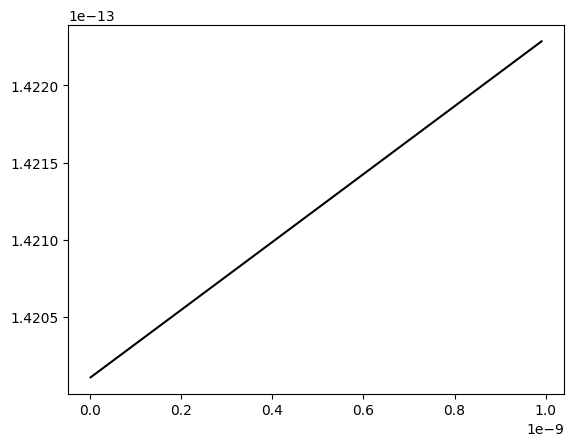

In [100]:
plt.plot(times[:], Temp[:], c='k')


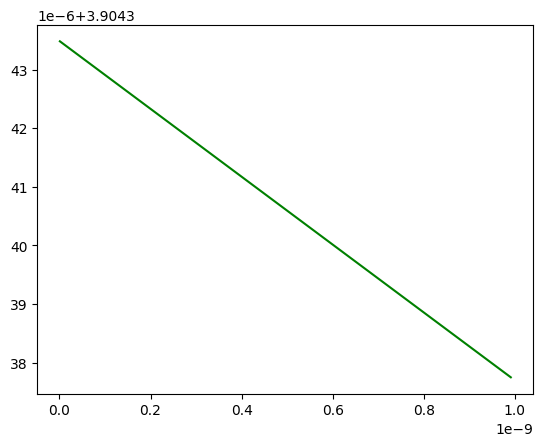

In [101]:
plt.plot(times[:], pair_dist[:], c = 'g')


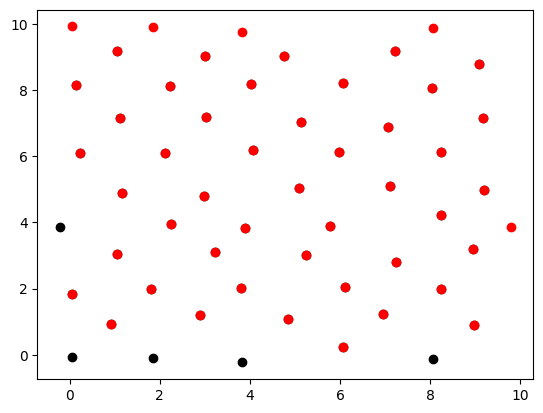

In [102]:
for i in range(0,N):
    plt.scatter(x_start[i],y_start[i],c='k')
    plt.scatter(x_final[i],y_final[i],c='r')
plt.show()


In [ ]:
###  Use this for Lennard Jones Potential  ##
###  (https://en.wikipedia.org/wiki/Lennard-Jones_potential)

def force(x_all,y_all):

    en = 0
    forces_x = [0.0]*N
    forces_y = [0.0]*N
    rc = 0.2
    eps = 1e-42

    for i in range (0,N-1):
        for j in range (i+1,N):
            xr = x_all[i] - x_all[j]
            xr = xr - box*np.round(xr/box)
            yr = y_all[i] - y_all[j]
            yr = yr - box*np.round(yr/box)

            r2 = xr*xr + yr*yr

            if r2 <= rc*rc:
                r2i = 1/r2
                r6i = np.power(r2i,3)
                ff = 48*eps*r2i*r6i*(r6i-0.5)
                forces_x[i] = forces_x[i] + ff*xr
                forces_x[j] = forces_x[j] - ff*xr
                forces_y[i] = forces_y[i] + ff*yr
                forces_y[j] = forces_y[j] - ff*yr
                en = (en + 4*eps*r6i*(r6i-1))

    return(en,forces_x,forces_y)
